# Regularyzacja w modelu regresji - wstęp

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` z `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [2]:
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + stats.norm.rvs(size=n, loc=2, scale=2)

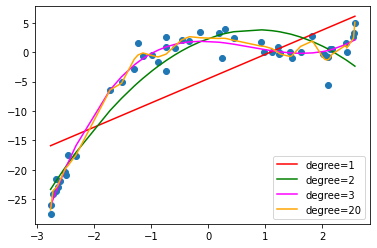

In [3]:
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanej pary punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [4]:
# Rigde
# Sposob I
X = x.reshape(-1, 1)
polynomial_features_20 = PolynomialFeatures(degree=20)
X20 = polynomial_features_20.fit_transform(X)

In [5]:
X20.shape

(50, 21)

In [6]:
X20

array([[ 1.00000000e+00,  2.57356530e+00,  6.62323837e+00, ...,
         2.45263809e+07,  6.31202428e+07,  1.62444067e+08],
       [ 1.00000000e+00,  1.46727241e+00,  2.15288834e+00, ...,
         9.93558745e+02,  1.45782134e+03,  2.13902104e+03],
       [ 1.00000000e+00, -2.76091539e+00,  7.62265377e+00, ...,
         8.68871884e+07, -2.39888175e+08,  6.62310954e+08],
       ...,
       [ 1.00000000e+00, -9.82508070e-01,  9.65322107e-01, ...,
         7.27864050e-01, -7.15132303e-01,  7.02623258e-01],
       [ 1.00000000e+00,  2.00913325e+00,  4.03661643e+00, ...,
         2.84549187e+05,  5.71697235e+05,  1.14861592e+06],
       [ 1.00000000e+00, -1.38506254e-01,  1.91839825e-02, ...,
         3.51924031e-16, -4.87436793e-17,  6.75130444e-18]])

In [ ]:
?StandardScaler

In [7]:
X20_scale = StandardScaler().fit_transform(X20) # (x - mean) / std
X20_scale

array([[ 0.        ,  1.4388811 ,  1.27488534, ...,  0.6589607 ,
         1.34415629,  0.5569249 ],
       [ 0.        ,  0.82820821, -0.43132407, ..., -0.49704087,
         0.31449303, -0.47261387],
       [ 0.        , -1.50574848,  1.65633465, ...,  3.59833087,
        -3.59885133,  3.72502532],
       ...,
       [ 0.        , -0.52406889, -0.88458538, ..., -0.49708767,
         0.31446924, -0.47262742],
       [ 0.        ,  1.12731501,  0.28764302, ..., -0.48367551,
         0.32379541, -0.46534763],
       [ 0.        , -0.05818048, -1.24570023, ..., -0.4970877 ,
         0.31446925, -0.47262743]])

In [8]:
?Ridge

In [9]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y)
ridge01

Ridge(alpha=0.1)

In [16]:
lm =  LinearRegression().fit(X20,y)

In [17]:
print(ridge01.coef_) # [wyraz wolny = 0, b1, b2, ..., b20]
print(lm.coef_)


[ 0.          0.53584087 -4.24383451  3.93193725 -1.39348686  2.84983917
 -1.02145248  0.76756771 -0.09106078 -0.52695473  0.8096896  -0.95938748
  1.30570567 -0.76704563  1.30745897 -0.14567565  0.8593909   0.77558278
  0.04965432  1.90983466 -1.03089159]
[ 0.00000000e+00 -5.58540000e-01  7.42553181e+00 -1.20292941e+00
 -6.18186174e+01  2.36282267e+01  1.29057086e+02 -4.75505625e+01
 -1.28996370e+02  4.07129692e+01  7.20577578e+01 -1.83436138e+01
 -2.41114511e+01  4.69218961e+00  4.94333319e+00 -6.85419590e-01
 -6.08612432e-01  5.32895629e-02  4.13223646e-02 -1.71102522e-03
 -1.18944451e-03]


In [20]:
print(ridge01.intercept_) # wyraz wolny
print(lm.intercept_) 

-4.63908109652509
2.2692360305653256


In [21]:
ridge01_params = [ridge01.intercept_] + list(ridge01.coef_[1:])
ridge01_params # wyraz wolny i wspolczynniki regresji

[-4.63908109652509,
 0.5358408669604445,
 -4.243834506366918,
 3.9319372479973644,
 -1.3934868556521105,
 2.8498391692378675,
 -1.0214524817163297,
 0.7675677121728613,
 -0.0910607799544517,
 -0.5269547251370162,
 0.8096895990160203,
 -0.9593874754700991,
 1.3057056736682475,
 -0.7670456328940529,
 1.3074589740532165,
 -0.14567565336719826,
 0.8593908987259019,
 0.7755827783465447,
 0.04965431508386612,
 1.9098346598677483,
 -1.0308915889131016]

In [22]:
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01.score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-4.63908109652509, 0.5358408669604445, -4.243834506366918, 3.9319372479973644, -1.3934868556521105, 2.8498391692378675, -1.0214524817163297, 0.7675677121728613, -0.0910607799544517, -0.5269547251370162, 0.8096895990160203, -0.9593874754700991, 1.3057056736682475, -0.7670456328940529, 1.3074589740532165, -0.14567565336719826, 0.8593908987259019, 0.7755827783465447, 0.04965431508386612, 1.9098346598677483, -1.0308915889131016]
R2: 0.9771084362686349


In [23]:
## Sposob 2

ridge01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20),
    StandardScaler(),
    Ridge(alpha=0.1)
)
ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [24]:
ridge01_pipeline['ridge']

Ridge(alpha=0.1)

In [25]:
ridge01_params = [ridge01_pipeline['ridge'].intercept_] + list(ridge01_pipeline['ridge'].coef_[1:])
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01_pipeline['ridge'].score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-4.63908109652509, 0.5358408669604445, -4.243834506366918, 3.9319372479973644, -1.3934868556521105, 2.8498391692378675, -1.0214524817163297, 0.7675677121728613, -0.0910607799544517, -0.5269547251370162, 0.8096895990160203, -0.9593874754700991, 1.3057056736682475, -0.7670456328940529, 1.3074589740532165, -0.14567565336719826, 0.8593908987259019, 0.7755827783465447, 0.04965431508386612, 1.9098346598677483, -1.0308915889131016]
R2: 0.9771084362686349


In [26]:
ridge01.predict(X20_scale)

array([  4.03608541,   0.06191948, -26.29009506, -16.45406009,
       -19.15849701, -26.29713314, -23.15809776, -21.74539325,
         1.95542073,   1.06741755, -24.79197414,   0.78972964,
         1.19973401,   0.12156283,   0.49098218,   0.74769151,
         0.73412931,  -4.3026156 ,   0.71868138,  -2.30940209,
       -19.62857119,  -0.75870766, -23.44313551,   0.55149242,
       -19.94935808,   3.26957452,  -6.64350261,   3.50772395,
       -22.65157672,  -1.23505892,   1.98629802,  -0.79245471,
         1.14682793,   0.57051284,   2.00564275,  -0.70017342,
         0.94815312,  -0.61906904,   1.84282101,   0.1795189 ,
        -0.25136438,  -1.82853773,   1.47905105,   0.71176645,
         1.72124048,  -0.80724455,  -0.78973309,  -0.3236873 ,
        -0.79944557,   1.93085636])

In [27]:
ridge01_fittedvalues = ridge01_pipeline.predict(X)
ridge01_fittedvalues

array([  4.03608541,   0.06191948, -26.29009506, -16.45406009,
       -19.15849701, -26.29713314, -23.15809776, -21.74539325,
         1.95542073,   1.06741755, -24.79197414,   0.78972964,
         1.19973401,   0.12156283,   0.49098218,   0.74769151,
         0.73412931,  -4.3026156 ,   0.71868138,  -2.30940209,
       -19.62857119,  -0.75870766, -23.44313551,   0.55149242,
       -19.94935808,   3.26957452,  -6.64350261,   3.50772395,
       -22.65157672,  -1.23505892,   1.98629802,  -0.79245471,
         1.14682793,   0.57051284,   2.00564275,  -0.70017342,
         0.94815312,  -0.61906904,   1.84282101,   0.1795189 ,
        -0.25136438,  -1.82853773,   1.47905105,   0.71176645,
         1.72124048,  -0.80724455,  -0.78973309,  -0.3236873 ,
        -0.79944557,   1.93085636])

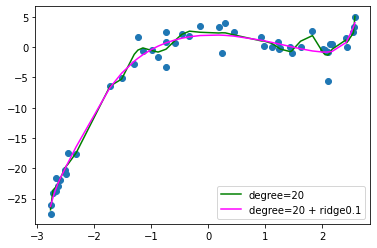

In [28]:
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))


plt.legend()

In [ ]:
?Lasso

In [29]:
lasso01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10e5)
)
lasso01_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=20)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=1000000.0))])

In [32]:
lasso01_params = [lasso01_pipeline['lasso'].intercept_] + list(lasso01_pipeline['lasso'].coef_[1:])
print("Współczynniki regresji z regularyzacja Lasso: {}".format(lasso01_params))
lasso01_r2 = lasso01_pipeline.score(X, y)
print("R2: {}".format(lasso01_r2))

Współczynniki regresji z regularyzacja Lasso: [-4.639081096525089, 0.12191672381742047, -4.3832463027312665, 4.16456213503237, -0.0, 2.823155451263987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999341121261249, 0.0, 0.0, 0.0, 0.0]
R2: 0.9733325557762743


In [33]:
lasso01_fittedvalues = lasso01_pipeline.predict(X)

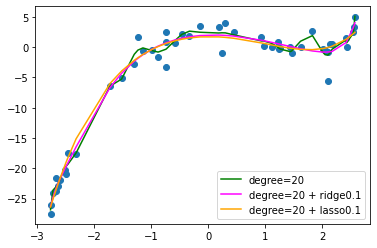

In [35]:
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianej stopnia 2, 10 i 20,
- wielomianej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

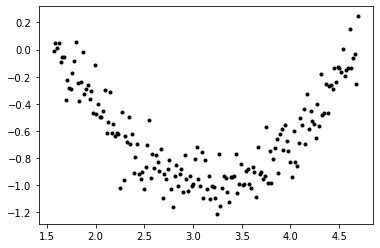

In [40]:
x = np.array([i*np.pi/180 for i in range(90,270,1)])
X = pd.DataFrame(x)
y = np.cos(x)+np.random.normal(0,0.15,len(x))
plt.plot(x,y,'.',color = 'black')

In [41]:
def fit_model(X,y,model,power):
  new_model = make_pipeline(
      PolynomialFeatures(power),
      StandardScaler(),
      model
  )
  new_model.fit(X,y)
  return(new_model.predict(X))

In [51]:
models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [52]:
def rss_fun(y,y_pred):
  return(sum((y-y_pred)**2))

In [53]:
y_pred_dict = {}
rss = {}
for key,values in zip(models,models.values()):
  y_pred = fit_model(X,y,values['model'],values['power'])
  y_pred_dict[key] = y_pred
  rss[key] = rss_fun(y_pred,y)

In [54]:
pd.DataFrame(list(rss.items()),columns = ['Model','RSS'])

,Model,RSS
0,linear_regression,20.714335
1,polynomial_regression2,2.878339
2,polynomial_regression10,2.737001
3,polynomial_regression20,2.652657
4,ridge_regression_0.1,2.895176
5,lasso_regression_0.1,16.629878


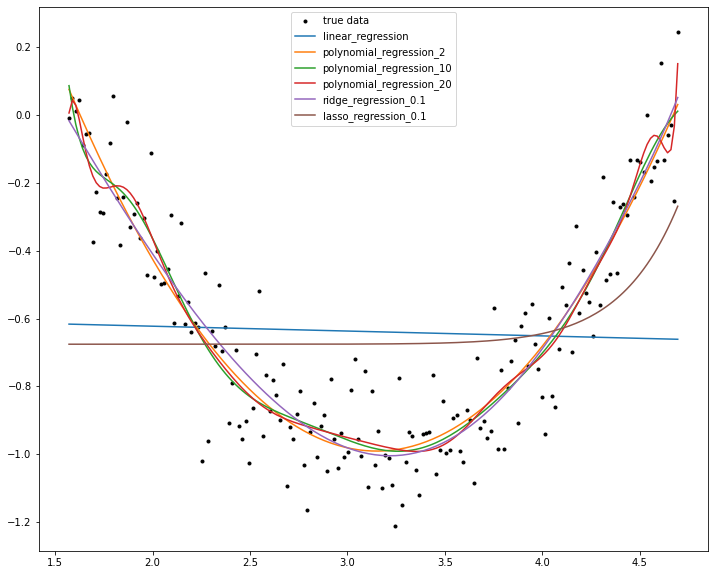

In [57]:
rcParams['figure.figsize'] = 12, 10

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")
for y_pred in y_pred_dict.values():
    plt.plot(x, y_pred)
plt.legend(labels)